## <font color="Greenyellow">Trabajo de Fin Master 3: Optimizacion de hiperparametros</font>
<a id="item0"></a> 

### <font color="Greenyellow">0. Indice</font>

* [1. Inicializacion del notebook](#item1)
* [2. ETL](#item2)
* [3. Modelos base](#item3)


***
<a id="item1"></a>
### <font color="Greenyellow">1. Inicializacion del notebook</font>

#### <font color="Greenyellow">1.1. Importacion de librerias</font>

In [14]:
# Analisis y transformacion de datos
import pandas as pd
import numpy as np
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Base de datos
import sqlite3
# Funciones propias en carpeta 'funciones
import funciones.funciones as funciones
# funciones machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import fbeta_score
# Optimizadores
from skopt import BayesSearchCV
from skopt.space import Real, Integer
# Modelos
import joblib


#### <font color="Greenyellow">1.2. Parametros del notebook</font>

In [2]:
carpeta_base_datos = 'bbdd'
nombre_bbdd        = 'base_datos_tfm.db'
semilla = 12345
pct_test=0.20

***
<a id="item2"></a>
### <font color="Greenyellow">2. ETL</font>
[Volver al indice](#item0)

In [3]:
# importamos los datos
df = funciones.query_bbdd(carpeta_base_datos, nombre_bbdd='base_datos_tfm.db', query='SELECT * FROM meta_df')

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,svm_score,ae_score,Class
0,-1.831394,1.107141,-1.204424,-1.226820,1.028445,-0.760374,1.323551,-0.357271,1.115512,2.062144,...,-0.227237,-1.826174,0.271514,0.313205,2.309268,1.237288,0.000300,0.494177,0.000118,0
1,1.848515,0.196144,-0.032262,2.877412,0.047466,0.391277,-0.177296,0.054035,-0.277311,1.114453,...,0.226368,1.955058,0.200332,0.156773,0.010514,-0.096330,0.000378,0.576759,0.000022,0
2,-1.053561,0.190965,-1.004245,0.498794,1.593853,-0.926626,1.057261,-0.368972,-0.145625,-0.498147,...,-0.019675,0.816888,-1.482848,-1.673466,-0.526134,2.332556,0.002702,0.341830,0.000609,0
3,-6.401023,2.233112,-1.327982,-1.842580,-2.295182,-0.120515,-2.404561,2.517392,1.893599,2.680617,...,0.708858,-1.292930,1.107814,-0.681156,-1.536555,-2.520797,0.000039,0.741960,0.001513,0
4,1.992540,-0.128910,-0.295624,0.213794,-0.177720,-0.107917,-0.345424,-0.034216,0.966190,-0.202261,...,0.610440,0.983131,-0.691763,-1.348371,0.104332,-0.067163,0.000340,0.446145,0.000008,0


In [5]:
# transformamos los datos y dividimos en train y test
X_train, X_test, y_train, y_test = funciones.preparar_datos(df, n_columnas_x=31, pct_test=pct_test, semilla=semilla)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)


***
<a id="item3"></a>
### <font color="Greenyellow">3. LightGBM</font>
[Volver al indice](#item0)

#### <font color="Greenyellow">3.1. Modelo sin optimizar</font>

1. Entrenando el modelo...
[LightGBM] [Info] Number of positive: 402, number of negative: 227443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001764 -> initscore=-6.338203
[LightGBM] [Info] Start training from score -6.338203
... entrenamiento completado.
    A. Precisión del modelo: 0.9949
    B. F1 Score: 0.3447
    C. AUC: 0.9711
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8444
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.22      0.84      0.34        90

    accuracy                           0.99     56962
   macro avg       0.61      0.92      0.67     56962
weighted 

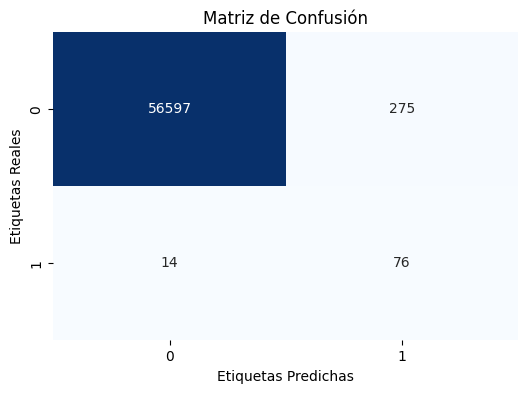


   Puntuaciones F1 de CV (k=5): [0.35170604 0.31081081 0.39296188 0.43125    0.42528736]
   Promedio de F1 de CV: 0.3824
CPU times: total: 22.9 s
Wall time: 14.6 s


In [6]:
%%time
# 1. Instanciamos el modelo
model = lgb.LGBMClassifier(objective='binary',
                           is_unbalance=True,
                           n_estimators=100,
                           learning_rate=0.01,
                           max_depth=7,
                           random_state=semilla,
                           n_jobs=-1)
# 2. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 3. Entrenamos el modelo
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 4. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

#### <font color="Greenyellow">3.2. Optimizacion de hiperparametros</font>

In [7]:
# Instanciamos el modelo a optimizar
model = lgb.LGBMClassifier(objective='binary', is_unbalance=True)

In [8]:
%%time
# Define el espacio de búsqueda
espacio_busqueda = {
    "n_estimators": Integer(50, 300),
    "max_depth": Integer(4, 30),
    "learning_rate": Real(0.01, 0.3, prior='log-uniform'),
    "num_leaves": Integer(50, 150)
}
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=semilla)
# Búsqueda Bayesiana
opt = BayesSearchCV(
    estimator=model,
    search_spaces=espacio_busqueda,
    scoring="average_precision",
    cv=cv,
    n_iter=30,
    n_jobs=10,
    verbose=0,
    random_state=semilla
)
# Entrenamiento del optimizador
opt.fit(X_train, y_train)
# Mejor resultado
print("Mejores parámetros encontrados:")
print(opt.best_params_)
print(f"Mejor puntuación average_precision (AUC-PR): {opt.best_score_:.4f}")

[LightGBM] [Info] Number of positive: 402, number of negative: 227443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001764 -> initscore=-6.338203
[LightGBM] [Info] Start training from score -6.338203
Mejores parámetros encontrados:
OrderedDict([('learning_rate', 0.016082047657415083), ('max_depth', 30), ('n_estimators', 300), ('num_leaves', 50)])
Mejor puntuación average_precision (AUC-PR): 0.8223
CPU times: total: 55 s
Wall time: 5min 20s


In [9]:
# Guardamos los mejores parametros con joblib
joblib.dump(opt.best_params_, 'data/parametros/lgbm_best_params.pkl')

['data/parametros/lgbm_best_params.pkl']

#### <font color="Greenyellow">3.3. Modelo optimizado</font>

In [10]:
# Cargamos los mejores parametros
best_params_lgb = ""
best_params_lgb = joblib.load('data/parametros/lgbm_best_params.pkl')
best_params_lgb

OrderedDict([('learning_rate', 0.016082047657415083),
             ('max_depth', 30),
             ('n_estimators', 300),
             ('num_leaves', 50)])

1. Entrenando el modelo...
[LightGBM] [Info] Number of positive: 402, number of negative: 227443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001764 -> initscore=-6.338203
[LightGBM] [Info] Start training from score -6.338203
... entrenamiento completado.
    A. Precisión del modelo: 0.9994
    B. F1 Score: 0.8065
    C. AUC: 0.9516
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8333
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.78      0.83      0.81        90

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted 

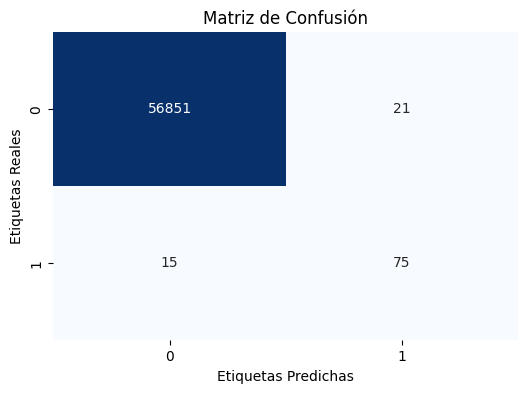


   Puntuaciones F1 de CV (k=5): [0.77011494 0.8427673  0.75739645 0.80981595 0.86956522]
   Promedio de F1 de CV: 0.8099
CPU times: total: 42.4 s
Wall time: 17.6 s


In [11]:
%%time
# 1. Instanciamos el modelo
model = lgb.LGBMClassifier(**best_params_lgb,
                           objective='binary',
                           is_unbalance=True,
                           random_state=semilla,
                           n_jobs=-1)
# 2. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 3. Entrenamos el modelo
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 4. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

In [16]:
f2_lgbm = fbeta_score(y_test, model.predict(X_test), beta=2, pos_label=1)
print(f'F2 score LightGBM: {f2_lgbm:.4f}')

F2 score LightGBM: 0.8224


In [17]:
# guardamos el f1 y recall_minoritaria en la carpeta de data mediante joblib
joblib.dump(f1, 'data/metricas/f1_lightgbm.pkl')
joblib.dump(recall_minoritaria, 'data/metricas/recall_lightgbm.pkl')
joblib.dump(f2_lgbm, 'data/metricas/f2_lightgbm.pkl')

['data/metricas/f2_lightgbm.pkl']

***
[Volver al indice](#item0)